# Predicting IBM 1-min-time series
* It is possible to get (ocationally) a signal with around 1% recall and around 80% precision using a regularized logistic regression
* If we managed to do this on many stocks we would be able to build a reasonable strategy from there.
* What if we negate the target and study NPV instead: recall improves ! (this idea might work !!!)
* Use naive Bayes: BernoulliNB out of the box is producing nice precision-recall curves
* What if we deal with class weights in the logistic regressions? class_weight
* Models are finding things, the behaviour is really not random. The fact that the thresholds in testing vs training are expected to be so different, maybe have to do with the way in which we are scaling things in our pipeline, also, PCA does seam to be helping a lot !!!!!!!!!!!!
* Again: can class weights help?

In [33]:
import sys
sys.path.append("/Users/lduque/Desktop/myProjects/moneyManager/marketUtilities")

In [34]:
cd ~/Desktop/MyProjects/moneyManager/

/Users/lduque/Desktop/myProjects/moneyManager


In [35]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from modeling.createTrainingDataSet import createTrainingDataSet
from modeling.StockModel import generatePipeline
#from modeling.plotPrecisionRecallThresholds import plotPrecisionRecallThresholds # soon to deprecate
from modeling.precisionRecallUtilities import plotTrainTestPrecisionRecallUsingModel
pd.set_option('display.max_columns', None)

In [36]:
startDay=datetime(2019,4,10)
endDay= datetime(2019,4,15)
df = createTrainingDataSet('MSFT',  startDay=startDay, endDay=endDay, pastStart=40)
df = df[['consolidated', 'volume', 'target']]

In [37]:
df.target.value_counts()

True     613
False    557
Name: target, dtype: int64

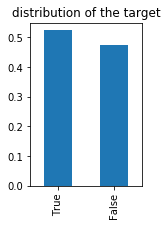

In [38]:
(df.target.value_counts()/len(df)).plot.bar(figsize=(2,3), title='distribution of the target');

In [39]:
df.volume.apply(lambda x: np.mean(x)).value_counts().sort_index()

11776.243902    1
11779.414634    1
11781.829268    1
11792.024390    1
11809.585366    1
               ..
91905.341463    1
92061.292683    1
92271.780488    1
92435.365854    1
93125.951220    1
Name: volume, Length: 1129, dtype: int64

In [40]:
X = df.copy()
y = X.pop('target')

In [41]:
trainEnds = len(X)-200
Xtrain, ytrain = X[:trainEnds], y[:trainEnds] 
Xtest, ytest = X[trainEnds:], y[trainEnds:]

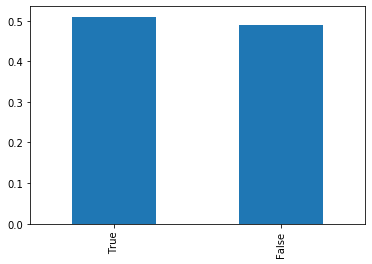

In [42]:
(ytest.value_counts()/len(ytest)).plot.bar()

In [43]:
(ytest.value_counts()/len(ytest))

True     0.51
False    0.49
Name: target, dtype: float64

In [44]:
(ytrain.value_counts()/len(ytrain))

True     0.526804
False    0.473196
Name: target, dtype: float64

# Debugging the pipeline
* So far we have 83 features

In [45]:
pipeline = generatePipeline()
pipeline.fit(Xtrain)
XtrainTrf = pipeline.transform(Xtrain)
XtestTrf = pipeline.transform(Xtest)
XtrainTrf.shape

/Users/lduque/Desktop/myProjects/moneyManager/venv-money/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/lduque/Desktop/myProjects/moneyManager/venv-money/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)


(970, 63)

In [46]:
XtestTrf.describe()

,consolidated_max,consolidated_argmax,consolidated_min,consolidated_argmin,consolidated_mean,consolidated_std,consolidated_var,consolidated_median,consolidated_kurtosis,consolidated_skew,consolidated_numpos,consolidated_posvar,consolidated_numnan,consolidated_last,consolidated_first,volume_max,volume_argmax,volume_min,volume_argmin,volume_mean,volume_std,volume_var,volume_median,volume_kurtosis,volume_skew,volume_numpos,volume_posvar,volume_numnan,volume_last,volume_first,consolidatedDifference_max,consolidatedDifference_argmax,consolidatedDifference_min,consolidatedDifference_argmin,consolidatedDifference_mean,consolidatedDifference_std,consolidatedDifference_var,consolidatedDifference_median,consolidatedDifference_kurtosis,consolidatedDifference_skew,consolidatedDifference_numpos,consolidatedDifference_posvar,consolidatedDifference_numnan,consolidatedDifference_last,consolidatedDifference_first,volumeDifference_max,volumeDifference_argmax,volumeDifference_min,volumeDifference_argmin,volumeDifference_mean,volumeDifference_std,volumeDifference_var,volumeDifference_median,volumeDifference_kurtosis,volumeDifference_skew,volumeDifference_numpos,volumeDifference_posvar,volumeDifference_numnan,volumeDifference_last,volumeDifference_first,hour,minute,hourminute
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.0,200.000000,200.000000,200.000000,200.00000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.0,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.0,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.0,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.049657,0.464000,0.913135,0.465625,0.473129,0.070067,0.012335,0.682209,0.037405,0.212372,0.744483,0.005722,0.0,0.336210,0.487473,0.293328,0.54625,0.218992,0.446375,0.504017,0.324226,0.203817,0.649702,0.303158,0.400589,0.695000,0.147145,0.0,0.094757,0.096832,0.054264,0.461154,0.940586,0.525128,0.463657,0.041845,0.012560,0.272726,0.054032,0.337430,0.726034,0.010105,0.0,0.339852,0.337219,0.380748,0.612308,0.694728,0.542949,0.452050,0.446130,0.355793,0.426022,0.225518,0.586493,0.786000,0.319570,0.0,0.411220,0.527895,0.688571,0.530508,0.720927
std,0.044513,0.349943,0.052611,0.309760,0.186162,0.042645,0.011404,0.022317,0.018811,0.076932,0.087125,0.008066,0.0,0.051544,0.042454,0.264495,0.30366,0.224972,0.317777,0.181750,0.222068,0.208202,0.164554,0.308305,0.281515,0.112324,0.210624,0.0,0.097588,0.090903,0.019531,0.290635,0.047531,0.308753,0.051786,0.038640,0.011373,0.074712,0.026743,0.047131,0.098337,0.005642,0.0,0.029284,0.026939,0.350113,0.300671,0.328373,0.336568,0.072792,0.348275,0.436638,0.277145,0.190549,0.114255,0.093336,0.451737,0.0,0.089232,0.071652,0.140876,0.301002,0.143863
min,-0.010047,0.000000,0.816164,0.000000,0.057843,0.018503,0.001952,0.620211,0.007379,0.031717,0.551724,-0.000671,0.0,0.214869,0.378621,0.026113,0.00000,-0.138304,0.000000,0.181818,0.054336,0.017949,0.282450,0.001599,0.036895,0.409091,0.004455,0.0,-0.010575,-0.007386,-0.000932,0.000000,0.831684,0.000000,0.361179,-0.046342,-0.009562,0.073050,0.011651,0.256571,0.551724,-0.000636,0.0,0.250745,0.274578,0.009576,0.000000,-0.046445,0.000000,0.022278,0.103216,0.037067,-0.126823,0.005523,0.138569,0.600000,0.005926,0.0,-0.140287,0.001457,0.428571,0.000000,0.463378
25%,0.018599,0.150000,0.855924,0.200000,0.348128,0.037997,0.004685,0.668385,0.024512,0.146028,0.689655,0.000867,0.0,0.304797,0.466946,0.127604,0.29375,-0.019371,0.150000,0.363636,0.205140,0.089673,0.540308,0.070944,0.180216,0.590909,0.030611,0.0,0.043816,0.042113,0.048371,0.205128,0.914573,0.250000,0.429009,0.021954,0.005667,0.216104,0.037066,0.302571,0.655172,0.007971,0.0,0.32297

In [47]:
XtestTrf.isna().sum()

consolidated_max          0
consolidated_argmax       0
consolidated_min          0
consolidated_argmin       0
consolidated_mean         0
                         ..
volumeDifference_last     0
volumeDifference_first    0
hour                      0
minute                    0
hourminute                0
Length: 63, dtype: int64

In [48]:
XtestTrf.describe()

,consolidated_max,consolidated_argmax,consolidated_min,consolidated_argmin,consolidated_mean,consolidated_std,consolidated_var,consolidated_median,consolidated_kurtosis,consolidated_skew,consolidated_numpos,consolidated_posvar,consolidated_numnan,consolidated_last,consolidated_first,volume_max,volume_argmax,volume_min,volume_argmin,volume_mean,volume_std,volume_var,volume_median,volume_kurtosis,volume_skew,volume_numpos,volume_posvar,volume_numnan,volume_last,volume_first,consolidatedDifference_max,consolidatedDifference_argmax,consolidatedDifference_min,consolidatedDifference_argmin,consolidatedDifference_mean,consolidatedDifference_std,consolidatedDifference_var,consolidatedDifference_median,consolidatedDifference_kurtosis,consolidatedDifference_skew,consolidatedDifference_numpos,consolidatedDifference_posvar,consolidatedDifference_numnan,consolidatedDifference_last,consolidatedDifference_first,volumeDifference_max,volumeDifference_argmax,volumeDifference_min,volumeDifference_argmin,volumeDifference_mean,volumeDifference_std,volumeDifference_var,volumeDifference_median,volumeDifference_kurtosis,volumeDifference_skew,volumeDifference_numpos,volumeDifference_posvar,volumeDifference_numnan,volumeDifference_last,volumeDifference_first,hour,minute,hourminute
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.0,200.000000,200.000000,200.000000,200.00000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.0,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.0,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.0,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.049657,0.464000,0.913135,0.465625,0.473129,0.070067,0.012335,0.682209,0.037405,0.212372,0.744483,0.005722,0.0,0.336210,0.487473,0.293328,0.54625,0.218992,0.446375,0.504017,0.324226,0.203817,0.649702,0.303158,0.400589,0.695000,0.147145,0.0,0.094757,0.096832,0.054264,0.461154,0.940586,0.525128,0.463657,0.041845,0.012560,0.272726,0.054032,0.337430,0.726034,0.010105,0.0,0.339852,0.337219,0.380748,0.612308,0.694728,0.542949,0.452050,0.446130,0.355793,0.426022,0.225518,0.586493,0.786000,0.319570,0.0,0.411220,0.527895,0.688571,0.530508,0.720927
std,0.044513,0.349943,0.052611,0.309760,0.186162,0.042645,0.011404,0.022317,0.018811,0.076932,0.087125,0.008066,0.0,0.051544,0.042454,0.264495,0.30366,0.224972,0.317777,0.181750,0.222068,0.208202,0.164554,0.308305,0.281515,0.112324,0.210624,0.0,0.097588,0.090903,0.019531,0.290635,0.047531,0.308753,0.051786,0.038640,0.011373,0.074712,0.026743,0.047131,0.098337,0.005642,0.0,0.029284,0.026939,0.350113,0.300671,0.328373,0.336568,0.072792,0.348275,0.436638,0.277145,0.190549,0.114255,0.093336,0.451737,0.0,0.089232,0.071652,0.140876,0.301002,0.143863
min,-0.010047,0.000000,0.816164,0.000000,0.057843,0.018503,0.001952,0.620211,0.007379,0.031717,0.551724,-0.000671,0.0,0.214869,0.378621,0.026113,0.00000,-0.138304,0.000000,0.181818,0.054336,0.017949,0.282450,0.001599,0.036895,0.409091,0.004455,0.0,-0.010575,-0.007386,-0.000932,0.000000,0.831684,0.000000,0.361179,-0.046342,-0.009562,0.073050,0.011651,0.256571,0.551724,-0.000636,0.0,0.250745,0.274578,0.009576,0.000000,-0.046445,0.000000,0.022278,0.103216,0.037067,-0.126823,0.005523,0.138569,0.600000,0.005926,0.0,-0.140287,0.001457,0.428571,0.000000,0.463378
25%,0.018599,0.150000,0.855924,0.200000,0.348128,0.037997,0.004685,0.668385,0.024512,0.146028,0.689655,0.000867,0.0,0.304797,0.466946,0.127604,0.29375,-0.019371,0.150000,0.363636,0.205140,0.089673,0.540308,0.070944,0.180216,0.590909,0.030611,0.0,0.043816,0.042113,0.048371,0.205128,0.914573,0.250000,0.429009,0.021954,0.005667,0.216104,0.037066,0.302571,0.655172,0.007971,0.0,0.32297

# Naive Bayes

In [49]:
clf = BernoulliNB()
clf.fit(XtrainTrf, ytrain); 

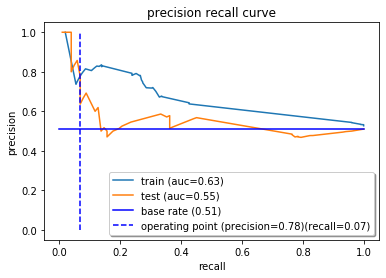

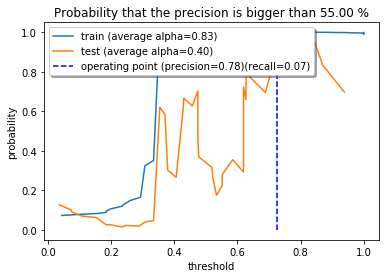

In [50]:
plotTrainTestPrecisionRecallUsingModel(clf, XtrainTrf, ytrain, XtestTrf, ytest, P=0.55, minimalCertainty=0.9)

# No regularization
* Performance is not awesome
* Huge overfit: notice how different precision and recall curves are.

In [51]:
clf =LogisticRegression(penalty='none', max_iter=10000)
clf.fit(XtrainTrf, ytrain);  

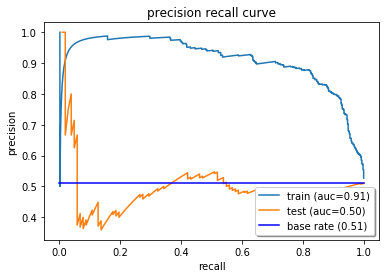

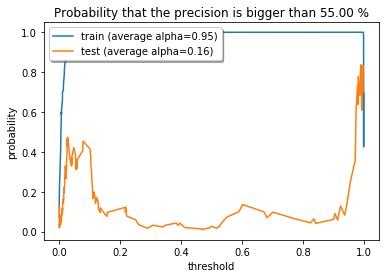

In [52]:
plotTrainTestPrecisionRecallUsingModel(clf, XtrainTrf, ytrain, XtestTrf, ytest)

# L1 regularization

In [53]:
C = 10**np.linspace(-4,1,50) 
grid_parameters = {
    'C': C,
    'penalty':['l1']
}

clf = GridSearchCV(LogisticRegression(solver='saga',max_iter=10000, multi_class='ovr', C=C), grid_parameters, scoring='average_precision', cv=2, return_train_score=True)
clf.fit(XtrainTrf, ytrain);  
test_scores = clf.cv_results_['mean_test_score']
train_scores = clf.cv_results_['mean_train_score']
ds = pd.DataFrame({'train_scores':train_scores, 'evaluation_scores':test_scores}, index=C)

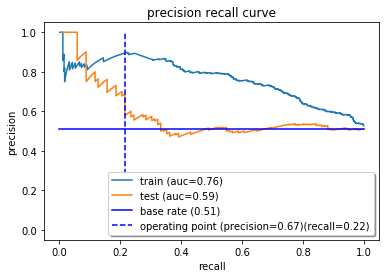

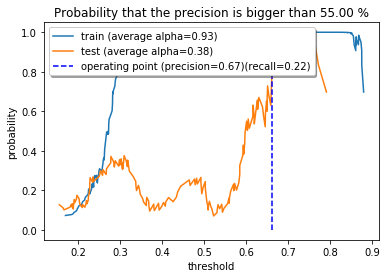

In [54]:
plotTrainTestPrecisionRecallUsingModel(clf, XtrainTrf, ytrain, XtestTrf, ytest)

0.7174878070440924
---
consolidatedDifference_min       1.299709
consolidated_argmax              1.266196
volumeDifference_median          0.714166
volume_argmax                    0.662057
consolidatedDifference_argmin    0.354680
                                   ...   
consolidatedDifference_var       0.000000
consolidatedDifference_std       0.000000
consolidatedDifference_mean      0.000000
minute                           0.000000
consolidated_max                 0.000000
Length: 63, dtype: float64
---
LogisticRegression(C=0.14563484775012445, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='ovr', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)


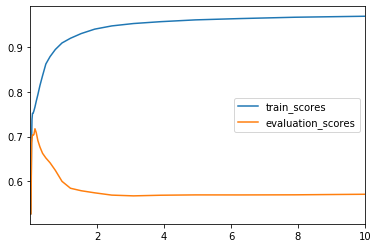

In [55]:
ds.plot()
print(ds.evaluation_scores.max())
print('---')
print(pd.Series(clf.best_estimator_.coef_[0], index=XtrainTrf.columns).abs().sort_values(ascending=False))
print('---')
print(clf.best_estimator_)

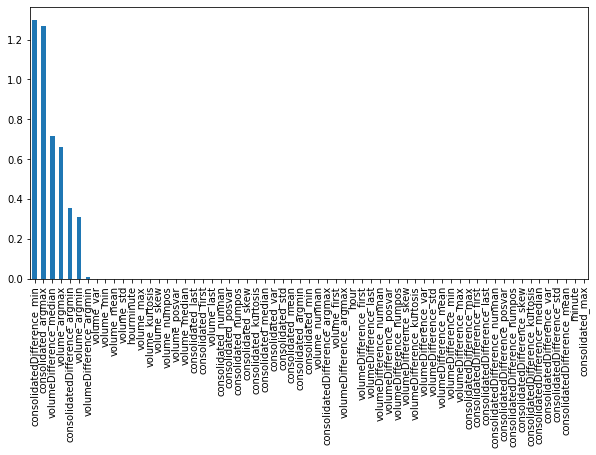

In [56]:
pd.Series(clf.best_estimator_.coef_[0], index=XtrainTrf.columns).abs().sort_values(ascending=False).plot.bar(figsize=(10,5));

# L2 regularization

In [57]:
C = 10**np.linspace(-5,0,100) 
grid_parameters = {
    'C': C,
    'penalty':['l2']
}

clf = GridSearchCV(LogisticRegression(solver='liblinear', multi_class='ovr', max_iter=10000, C=C), grid_parameters, scoring='average_precision', cv=3, return_train_score=True)
clf.fit(XtrainTrf, ytrain);  
test_scores = clf.cv_results_['mean_test_score']
train_scores = clf.cv_results_['mean_train_score']
ds = pd.DataFrame({'train_scores':train_scores, 'evaluation_scores':test_scores}, index=C)

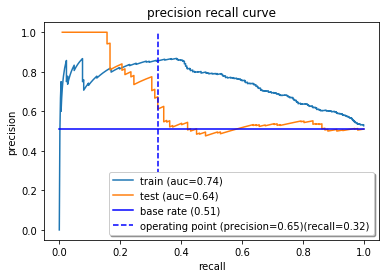

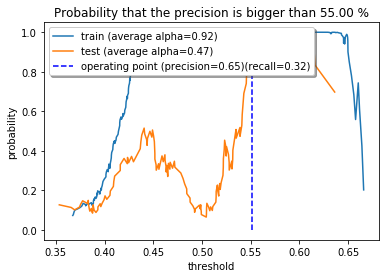

In [58]:
plotTrainTestPrecisionRecallUsingModel(clf, XtrainTrf, ytrain, XtestTrf, ytest)

0.6491983952311102
---
consolidated_argmax              0.344943
volume_argmax                    0.255447
consolidatedDifference_min       0.162248
consolidatedDifference_argmin    0.143536
volume_argmin                    0.137726
                                   ...   
volumeDifference_std             0.004391
volume_std                       0.003993
volumeDifference_var             0.003727
consolidated_mean                0.003611
volumeDifference_max             0.001154
Length: 63, dtype: float64
---
LogisticRegression(C=0.010722672220103232, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


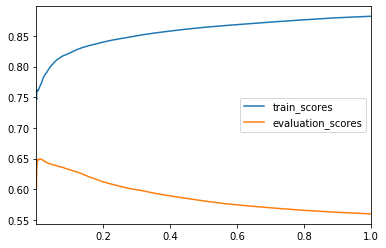

In [59]:
ds.plot()
print(ds.evaluation_scores.max())
print('---')
print(pd.Series(clf.best_estimator_.coef_[0], index=XtrainTrf.columns).abs().sort_values(ascending=False))
print('---')
print(clf.best_estimator_)

# Random Forest
* Horrible overift ... for now! ... unexpectedly hard to control !!

In [60]:
grid_parameters = {
    #'min_samples_leaf' : [100, 1000, 2000],
    'max_depth': [2, 3, 4, 5, 6, 7, 8,9, 10],
    'n_estimators': [5, 10, 100],   
    'max_features': ['sqrt', 0.1, 0.2, 0.5, 0.8]
}

clf = GridSearchCV(RandomForestClassifier(), grid_parameters, scoring='average_precision', cv=3, return_train_score=True)
clf.fit(XtrainTrf, ytrain);  
test_scores = clf.cv_results_['mean_test_score']
train_scores = clf.cv_results_['mean_train_score']
ds = pd.DataFrame({'train_scores':train_scores, 'evaluation_scores':test_scores})

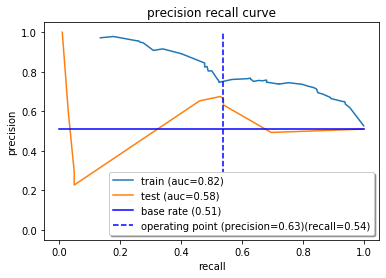

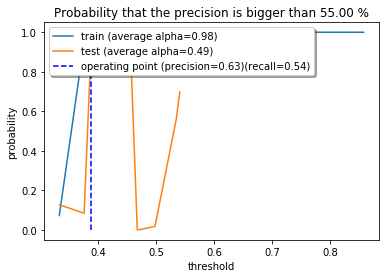

In [61]:
plotTrainTestPrecisionRecallUsingModel(clf, XtrainTrf, ytrain, XtestTrf, ytest)

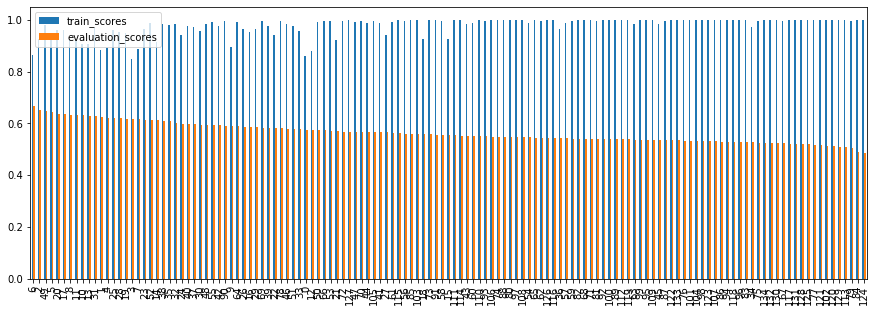

In [62]:
ds.sort_values(by='evaluation_scores', ascending=False).plot.bar(figsize=(15,5))

In [63]:
clf.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features=0.2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

feature importance


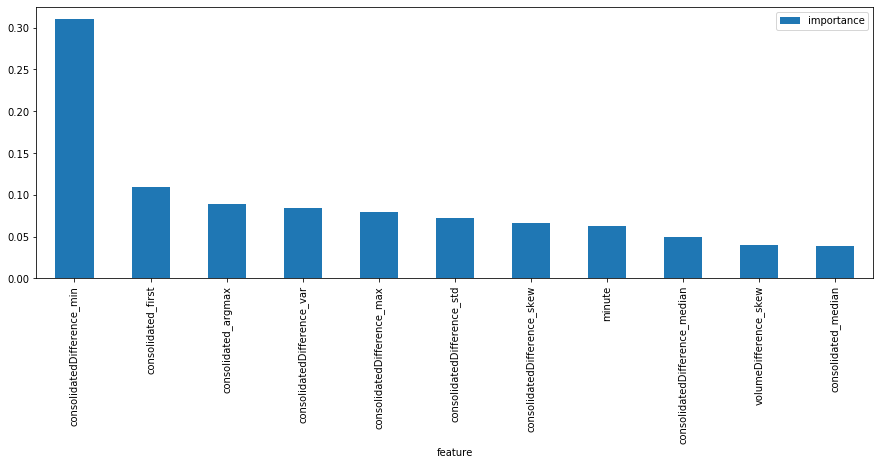

In [64]:
print("feature importance")
feature_importance = pd.DataFrame({'feature': XtrainTrf.columns, 'importance':clf.best_estimator_.feature_importances_}).set_index('feature').sort_values(by=['importance'], ascending=False)
feature_importance[feature_importance.importance>0].plot.bar(figsize=(15,5))